# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize -- This has been deprecated
from scipy import misc
import imageio
#import imageio.v2 as imageio
import datetime
import os
import cv2 #install opencv-python
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30) #Getting deprecated error
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size_temp = 20 #experiment with the batch size

In [4]:
num_classes=5 # number of classes
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
channels=3

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
#num_epochs = 5 # choose the number of epochs  
#print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


In [5]:
#Setting some of the Processing Atributes
image_count1 = 30 # number of images to be used for each video
image_height_temp= 120 #160
image_width_temp= 120 #160
input_shape=(image_count1,image_width_temp,image_height_temp,channels)


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size, frames_to_sample=20, augment=False, total_sample=30, image_width=160, image_height=160):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = [x for x in range(0,total_sample)] #create a list of image numbers you want to use for a particular video
    img_idx = np.round(np.linspace(0,total_sample-1,frames_to_sample)).astype(int) #Randomize the picking of frames too.
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,total_sample,image_width,image_height,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,num_classes)) # batch_labels is the one hot representation of the output
 
            if (augment): 
                batch_data_aug = np.zeros((batch_size,total_sample,image_width,image_height,channels))

            #batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            #batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = misc.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = cv2.resize(image,(image_width,image_height))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                    if (augment):
                        shifted = cv2.warpAffine(image, 
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                                (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 

                        cropped=shifted[x0:x1,y0:y1,:]
                        
                        image_resized = cv2.resize(cropped,(image_width,image_height))
                        
                        M = cv2.getRotationMatrix2D((image_width//2,image_height//2),
                                                np.random.randint(-10,10), 1.0)
                        temp = cv2.warpAffine(image_resized, M, (image_width,image_height))

                        temp = temp/255 #Normalize data

                        #image_resized=imresize(cropped,(self.image_height,self.image_width,3))


                        batch_data_aug[folder,idx,:,:,0] = (temp[:,:,0])
                        batch_data_aug[folder,idx,:,:,1] = (temp[:,:,1])
                        batch_data_aug[folder,idx,:,:,2] = (temp[:,:,2])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size1 = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size1,total_sample,image_width,image_height,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size1,num_classes)) # batch_labels is the one hot representation of the output
 
            if (augment): 
                batch_data_aug = np.zeros((batch_size1,total_sample,image_width,image_height,channels))

            for folder in range(batch_size1): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size1)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = misc.imread(source_path+'/'+ t[folder + (batch*batch_size1)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = io.imread(source_path+'/'+ t[folder + (batch*batch_size1)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size1)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)                    
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size1)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = cv2.resize(image,(image_width,image_height))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                    if (augment):
                        shifted = cv2.warpAffine(image, 
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                                (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 

                        cropped=shifted[x0:x1,y0:y1,:]
                        
                        image_resized = cv2.resize(cropped,(image_width,image_height))
                        
                        M = cv2.getRotationMatrix2D((image_width//2,image_height//2),
                                                np.random.randint(-10,10), 1.0)
                        temp = cv2.warpAffine(image_resized, M, (image_width,image_height))

                        temp = temp/255 #Normalize data

                        #image_resized=imresize(cropped,(self.image_height,self.image_width,3))

                        batch_data_aug[folder,idx,:,:,0] = (temp[:,:,0])
                        batch_data_aug[folder,idx,:,:,1] = (temp[:,:,1])
                        batch_data_aug[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size1)].strip().split(';')[2])] = 1

            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            
            yield batch_data, batch_labels


In [7]:
def trigger_model(model, train_path, train_doc, batch_size,augment=False, frames_to_sample=16, total_frames=30, epochs=5, image_width=160, image_height=160):
    
    train_generator = generator(train_path, train_doc, batch_size,augment, frames_to_sample, total_frames, image_width, image_height)
    val_generator = generator(val_path, val_doc, batch_size,augment, frames_to_sample, total_frames, image_width, image_height)
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq =1)

    LR = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,factor=0.2)# write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
                  callbacks=callbacks_list, validation_data=val_generator,
                 validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)
    
    return history

In [25]:
def plot_graph(history,epochs):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
#from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, ConvLSTM2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

In [10]:
#Model 1

def define_model1(image_width=160,image_height=160,frame_count=30):
    
    model_shape=(frame_count,image_width,image_height,channels)
    
    model1 = Sequential()
    #model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)))
    model1.add(Conv3D(16, (3, 3, 3), activation='relu', padding = 'Same', input_shape=model_shape))
    model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model1.add(Dropout(0.25))

    model1.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding = 'Same'))
    model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model1.add(Dropout(0.25))

    model1.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',padding = 'Same'))
    model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model1.add(Dropout(0.25))

    model1.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu',padding = 'Same'))
    model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model1.add(Dropout(0.25))

    model1.add(Flatten())

    #Option 1 for Hidden Layers
    #model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(9,activation='softmax'))

    #Trying a different combination of hidden layers
    model1.add(Dense(128, activation='relu'))
    model1.add(Dropout(0.25))
    model1.add(Dense(64, activation='relu'))
    model1.add(Dropout(0.25))
    model1.add(Dense(num_classes,activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model1
    #print (model1.summary())


In [18]:
#Model 2 - changing the Layer Size and adding Normalization
def define_model2(image_width=160,image_height=160,frame_count=30):
    
    model_shape=(frame_count,image_width,image_height,channels)

    model2 = Sequential()
    #model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)))
    model2.add(Conv3D(32, (3, 3, 3), activation='relu', padding = 'Same', input_shape=model_shape))
    model2.add(BatchNormalization())
    model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model2.add(Dropout(0.25))

    model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',padding = 'Same'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model2.add(Dropout(0.25))

    model2.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu',padding = 'Same'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model2.add(Dropout(0.25))

    model2.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding = 'Same'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model2.add(Dropout(0.25))


    model2.add(Flatten())

    #Trying a different combination of hidden layers
    #model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.25))
    #model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.25))
    model2.add(Dense(128, activation='relu'))
    model2.add(Dropout(0.25))
    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(0.25))
    model2.add(Dense(num_classes,activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model2

In [19]:
#Model 3 - Keeping the Layer Size the same from Model 3 and removing the BatchNormalization
def define_model3(image_width=160,image_height=160,frame_count=30):
    
    model_shape=(frame_count,image_width,image_height,channels)

    model3 = Sequential()
    #model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)))
    model3.add(Conv3D(32, (3, 3, 3), activation='relu', padding = 'Same', input_shape=model_shape))
    #model.add(BatchNormalization())
    model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model3.add(Dropout(0.25))

    model3.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',padding = 'Same'))
    #model.add(BatchNormalization())
    model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model3.add(Dropout(0.25))

    model3.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu',padding = 'Same'))
    #model.add(BatchNormalization())
    model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model3.add(Dropout(0.25))

    model3.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding = 'Same'))
    #model.add(BatchNormalization())
    model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model3.add(Dropout(0.25))

    model3.add(Flatten())

    #Trying a different combination of hidden layers
    #model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.25))
    #model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.25))
    model3.add(Dense(128, activation='relu'))
    model3.add(Dropout(0.25))
    model3.add(Dense(64, activation='relu'))
    model3.add(Dropout(0.25))
    model3.add(Dense(num_classes,activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model3

In [20]:
#Model 4 - Modifying Model 3 to use TimeDistribution and batch Normalization 
def define_model4(image_width=160,image_height=160,frame_count=30):
    
    model_shape=(frame_count,image_width,image_height,channels)
    
    model4 = Sequential()

    model4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=model_shape))
    model4.add(TimeDistributed(BatchNormalization()))
    model4.add(TimeDistributed(MaxPooling2D((2, 2))))

    model4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model4.add(TimeDistributed(BatchNormalization()))
    model4.add(TimeDistributed(MaxPooling2D((2, 2))))

    model4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model4.add(TimeDistributed(BatchNormalization()))
    model4.add(TimeDistributed(MaxPooling2D((2, 2))))

    model4.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model4.add(TimeDistributed(BatchNormalization()))
    model4.add(TimeDistributed(MaxPooling2D((2, 2))))

    model4.add(TimeDistributed(Flatten()))

    model4.add(GRU(128))
    model4.add(Dropout(0.25))

    model4.add(Dense(64,activation='relu'))
    model4.add(Dropout(0.25))

    model4.add(Dense(num_classes, activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model4

In [21]:
#Model 5 - Modifying Model 4 with increase in Dense Neurons to 128 and no Batch Normalization

def define_model5(image_width=160,image_height=160,frame_count=30):

    model_shape=(frame_count,image_width,image_height,channels)

    model5 = Sequential()

    model5.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=model_shape))
    #model5.add(TimeDistributed(BatchNormalization()))
    model5.add(TimeDistributed(MaxPooling2D((2, 2))))

    model5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    #model5.add(TimeDistributed(BatchNormalization()))
    model5.add(TimeDistributed(MaxPooling2D((2, 2))))

    model5.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    #model5.add(TimeDistributed(BatchNormalization()))
    model5.add(TimeDistributed(MaxPooling2D((2, 2))))

    model5.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    #model5.add(TimeDistributed(BatchNormalization()))
    model5.add(TimeDistributed(MaxPooling2D((2, 2))))

    model5.add(TimeDistributed(Flatten()))

    model5.add(GRU(128))
    model5.add(Dropout(0.25))

    model5.add(Dense(128,activation='relu'))
    model5.add(Dropout(0.25))

    model5.add(Dense(num_classes, activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model5

In [32]:
#Model 6 - Modifying Model 5 with dropouts and Dense Layer having 128 neurons
def define_model6(image_width=160,image_height=160,frame_count=30):

    model_shape=(frame_count,image_width,image_height,channels)
    
    model6 = Sequential()

    model6.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=model_shape))
    #model6.add(TimeDistributed(BatchNormalization()))
    model6.add(TimeDistributed(MaxPooling2D((2, 2))))
    model6.add(Dropout(0.25))

    model6.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    #model6.add(TimeDistributed(BatchNormalization()))
    model6.add(TimeDistributed(MaxPooling2D((2, 2))))
    model6.add(Dropout(0.25))

    model6.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    #model6.add(TimeDistributed(BatchNormalization()))
    model6.add(TimeDistributed(MaxPooling2D((2, 2))))
    model6.add(Dropout(0.25))

    model6.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    #model6.add(TimeDistributed(BatchNormalization()))
    model6.add(TimeDistributed(MaxPooling2D((2, 2))))
    model6.add(Dropout(0.25))

    model6.add(TimeDistributed(Flatten()))

    model6.add(GRU(128))
    model6.add(Dropout(0.25))

    model6.add(Dense(128,activation='relu'))
    model6.add(Dropout(0.25))

    model6.add(Dense(num_classes, activation='softmax'))

    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model6

In [41]:
input_shape=(16,image_width,image_height,channels)

model8 = Sequential()

model8.add(Conv3D(8, (3, 3, 3), padding='same',
         input_shape=(16,image_height,image_width,channels)))
model8.add(Activation('relu'))
model8.add(BatchNormalization())
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8.add(Conv3D(16, (3, 3, 3), padding='same'))
model8.add(Activation('relu'))
model8.add(BatchNormalization())
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8.add(Conv3D(32, (2, 2, 2), padding='same'))
model8.add(Activation('relu'))
model8.add(BatchNormalization())
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8.add(Conv3D(64, (2, 2, 2), padding='same'))
model8.add(Activation('relu'))
model8.add(BatchNormalization())
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8.add(Flatten())
model8.add(Dense(64,activation='relu'))
model8.add(BatchNormalization())
model8.add(Dropout(0.25))

model8.add(Dense(64,activation='relu'))
model8.add(BatchNormalization())
model8.add(Dropout(0.25))

model8.add(Dense(num_classes,activation='softmax'))

#optimiser = optimizers.Adam(lr=0.0002)
#model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#return model

In [19]:
#Model 8 - Using CNN + LSTM

model8 = Sequential()
model8.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
model8.add(BatchNormalization())

model8.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model8.add(BatchNormalization())

model8.add(ConvLSTM2D(32, kernel_size = 3, return_sequences=False))
model8.add(BatchNormalization())

model8.add(TimeDistributed(Dense(64, activation='relu')))
model8.add(BatchNormalization())

model8.add(GlobalAveragePooling2D())
model8.add(Dense(64, activation='relu'))
model8.add(Dense(num_classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [102]:
#optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
#model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model3.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 120, 120, 32   2624      
                             )                                   
                                                                 
 max_pooling3d_16 (MaxPooli  (None, 10, 60, 60, 32)    0         
 ng3D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 10, 60, 60, 32)    0         
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_17 (MaxPooli  (None, 5, 30, 30, 64)     0         
 ng3D)                                                           
                                                      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/5


34/34 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.1961Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2711_29_37.699984\model-00001-1.60946-0.19608-1.60939-0.23000.h5
34/34 [==============================] - 169s 5s/step - loss: 1.6095 - categorical_accuracy: 0.1961 - val_loss: 1.6094 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/5


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.2081
Epoch 2: saving model to model_init_2024-02-2711_29_37.699984\model-00002-1.60944-0.20814-1.60914-0.25000.h5
34/34 [==============================] - 161s 5s/step - loss: 1.6094 - categorical_accuracy: 0.2081 - val_loss: 1.6091 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.2097
Epoch 3: saving model to model_init_2024-02-2711_29_37.699984\model-00003-1.60938-0.20965-1.60925-0.21000.h5
34/34 [==============================] - 184s 5s/step - loss: 1.6094 - categorical_accuracy: 0.2097 - val_loss: 1.6093 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 4/5
34/34 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.2081
Epoch 4: saving model to model_init_2024-02-2711_29_37.699984\model-00004-1.60937-0.20814-1.60932-0.20000.h5
34/34 [===================

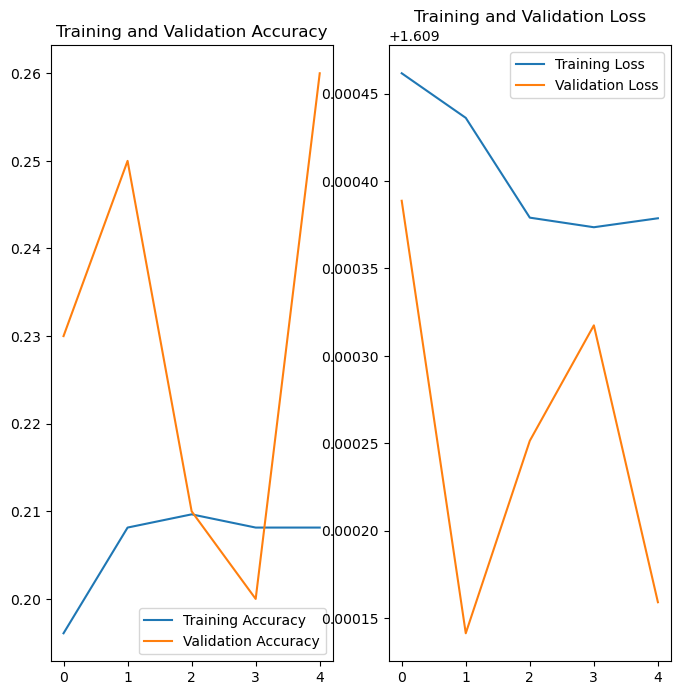

In [18]:
model1 = define_model1()
history1 = trigger_model(model1, train_path,train_doc, batch_size=20,augment=False,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=10)
plot_graph(history1)


Source path =  ./Project_data/train ; batch size = 30
Epoch 1/10


23/23 [==============================] - ETA: 0s - loss: 1.6204 - categorical_accuracy: 0.1916Source path =  ./Project_data/val ; batch size = 30
Batch:  4 Index: 30

Epoch 1: saving model to model_init_2024-02-2712_14_21.775741\model-00001-1.62042-0.19155-1.60887-0.16000.h5
23/23 [==============================] - 221s 9s/step - loss: 1.6204 - categorical_accuracy: 0.1916 - val_loss: 1.6089 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.6065 - categorical_accuracy: 0.2097 Batch:  4 Index: 30

Epoch 2: saving model to model_init_2024-02-2712_14_21.775741\model-00002-1.60649-0.20965-1.60771-0.17500.h5
23/23 [==============================] - 252s 11s/step - loss: 1.6065 - categorical_accuracy: 0.2097 - val_loss: 1.6077 - val_categorical_accuracy: 0.1750 - lr: 2.0000e-04
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.6032 - categorical_accuracy: 0.2127 Batch:  4 Index: 30

Epoch 3: saving model to model_init_2024-02-2712_14_21.775741\model-00003-1.60316-0.21267-1.60517-0.29500.h5
23/23 [==============================] - 264s 11s/step - loss: 1.6032 - categorical_accuracy: 0.2127 - val_loss: 1.6052 - val_categorical_accuracy: 0.2950 - lr: 2.0000e-04
Epoch 4/10
23/23 [==============================] - ETA: 0s - loss: 1.5949 - categorical_accuracy: 0.2262 Batch:  4 Index: 30
Batch:  4 Index: 30

Epoch 4: saving model to model_init_2

ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

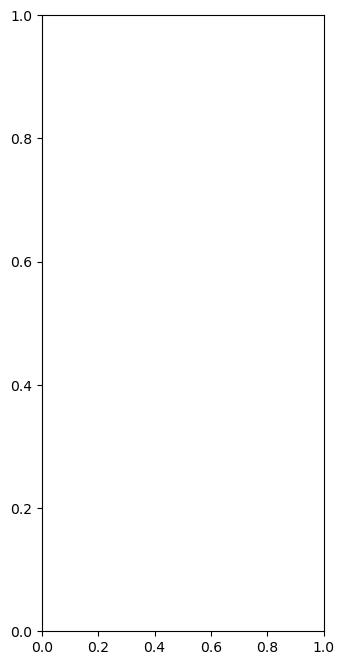

In [16]:
model1 = define_model1()
history1 = trigger_model(model1, train_path,train_doc, batch_size=30,augment=True,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=10)
plot_graph(history1,epochs=10)

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.1870 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2619_55_42.136406\model-00001-1.60948-0.18703-1.60945-0.21000.h5
34/34 [==============================] - 730s 22s/step - loss: 1.6095 - categorical_accuracy: 0.1870 - val_loss: 1.6094 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.2066 
Epoch 2: saving model to model_init_2024-02-2619_55_42.136406\model-00002-1.60943-0.20664-1.60941-0.18000.h5
34/34 [==============================] - 579s 17s/step - loss: 1.6094 - categorical_accuracy: 0.2066 - val_loss: 1.6094 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.2051 
Epoch 3: savin

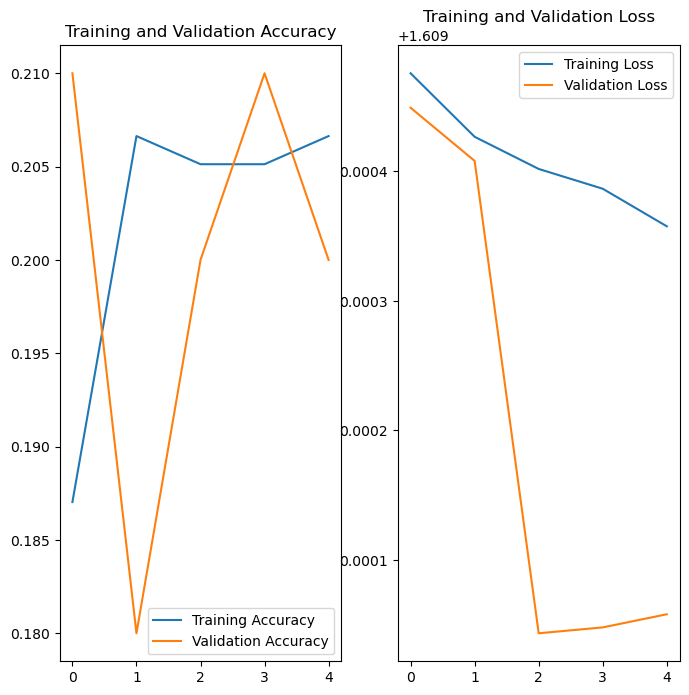

In [14]:
model2 = define_model2()
history2 = trigger_model(model2, train_path, train_doc, batch_size, augment=False, frames_to_sample=16, total_frames=30)
plot_graph(history2)

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 2.6844 - categorical_accuracy: 0.2059 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2619_55_42.136406\model-00001-2.68444-0.20588-2.06011-0.16000.h5
34/34 [==============================] - 482s 14s/step - loss: 2.6844 - categorical_accuracy: 0.2059 - val_loss: 2.0601 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 1.6861 - categorical_accuracy: 0.2225 
Epoch 2: saving model to model_init_2024-02-2619_55_42.136406\model-00002-1.68613-0.22247-2.58618-0.17000.h5
34/34 [==============================] - 505s 15s/step - loss: 1.6861 - categorical_accuracy: 0.2225 - val_loss: 2.5862 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 1.6130 - categorical_accuracy: 0.2210 
Epoch 3: savin

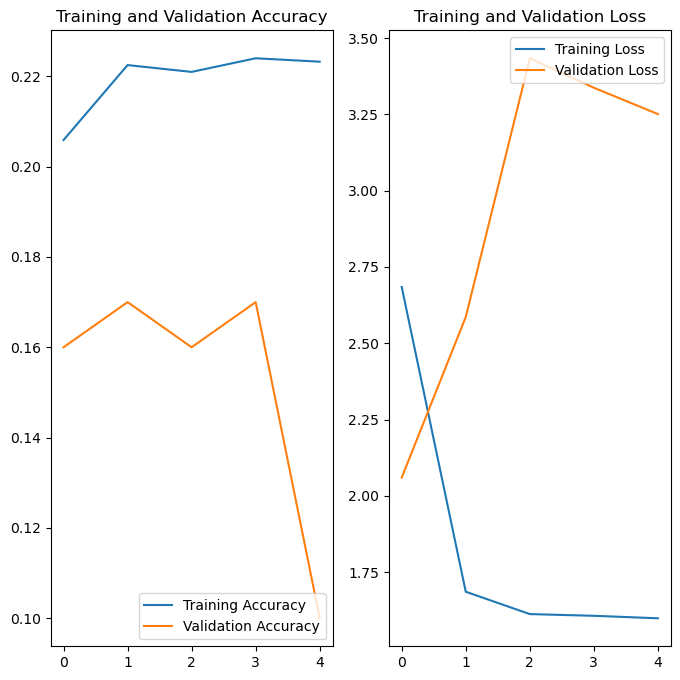

In [19]:
model2 = define_model2()
history2 = trigger_model(model2, train_path, train_doc, batch_size, augment=True, frames_to_sample=16, total_frames=30)
plot_graph(history2)

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 3.8745 - categorical_accuracy: 0.2300  Source path =  ./Project_data/val ; batch size = 30
Batch:  4 Index: 30

Epoch 1: saving model to model_init_2024-02-2712_14_21.775741\model-00001-3.87448-0.23002-5.63987-0.19000.h5
23/23 [==============================] - 2428s 105s/step - loss: 3.8745 - categorical_accuracy: 0.2300 - val_loss: 5.6399 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.6963 - categorical_accuracy: 0.2089  Batch:  4 Index: 30
Batch:  4 Index: 30

Epoch 2: saving model to model_init_2024-02-2712_14_21.775741\model-00002-1.69635-0.20890-9.87400-0.11000.h5
23/23 [==============================] - 2238s 98s/step - loss: 1.6963 - categorical_accuracy: 0.2089 - val_loss: 9.8740 - val_categorical_accuracy: 0.1100 - lr: 2.0000e-04
Epoch 3/10
23/23 [==============================] - E

ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

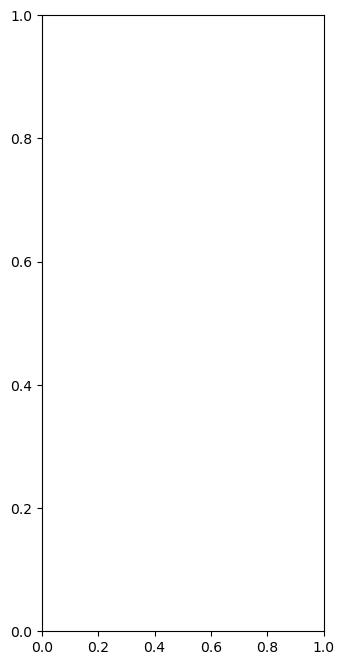

In [24]:
model2 = define_model2()
history2 = trigger_model(model2, train_path, train_doc, batch_size=30, augment=True, frames_to_sample=30, total_frames=30,image_width=160,image_height=160,epochs=10)
plot_graph(history2, epochs=10)

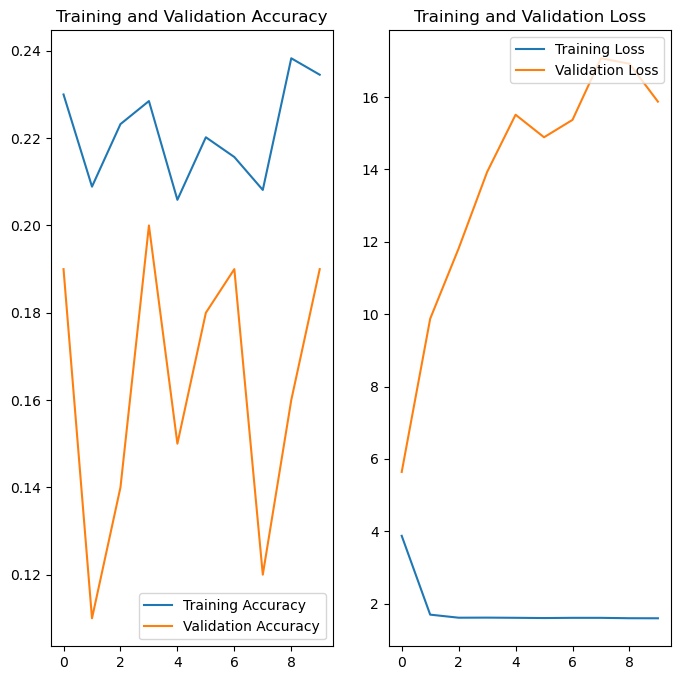

In [26]:
plot_graph(history2, epochs=10)


Source path =  ./Project_data/train ; batch size = 20
Epoch 1/5


34/34 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.1961 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2619_55_42.136406\model-00001-1.60946-0.19608-1.60939-0.23000.h5


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 459s 14s/step - loss: 1.6095 - categorical_accuracy: 0.1961 - val_loss: 1.6094 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.2081 
Epoch 2: saving model to model_init_2024-02-2619_55_42.136406\model-00002-1.60944-0.20814-1.60928-0.21000.h5
34/34 [==============================] - 923s 27s/step - loss: 1.6094 - categorical_accuracy: 0.2081 - val_loss: 1.6093 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.2097 
Epoch 3: saving model to model_init_2024-02-2619_55_42.136406\model-00003-1.60938-0.20965-1.60925-0.23000.h5
34/34 [==============================] - 812s 24s/step - loss: 1.6094 - categorical_accuracy: 0.2097 - val_loss: 1.6092 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 4/5
34/34 [==============================] - ETA

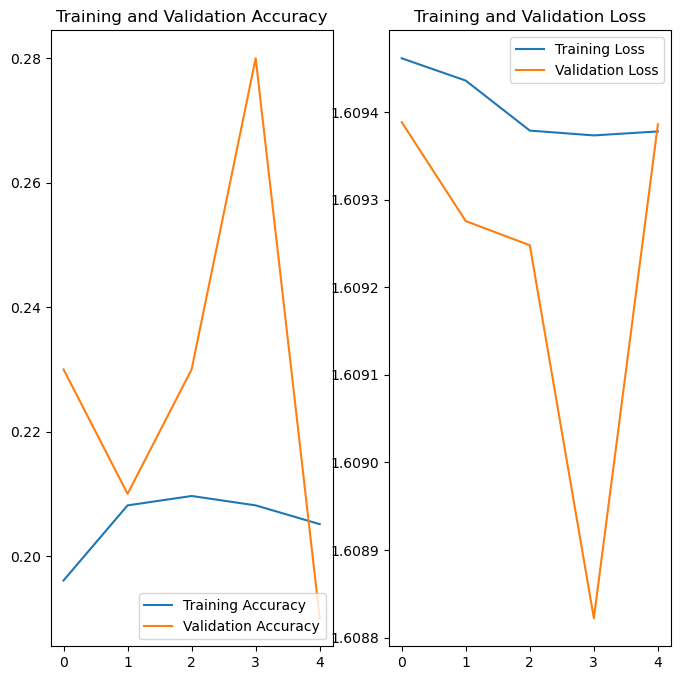

In [11]:
model3 = define_model3()
history3 = trigger_model(model3, train_path, train_doc, batch_size, augment=False, frames_to_sample=16, total_frames=30)
plot_graph(history3)

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 1.6144 - categorical_accuracy: 0.2051Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2619_55_42.136406\model-00001-1.61436-0.20513-1.60847-0.23000.h5
34/34 [==============================] - 327s 10s/step - loss: 1.6144 - categorical_accuracy: 0.2051 - val_loss: 1.6085 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 1.6069 - categorical_accuracy: 0.2081 
Epoch 2: saving model to model_init_2024-02-2619_55_42.136406\model-00002-1.60689-0.20814-1.60398-0.24000.h5
34/34 [==============================] - 407s 12s/step - loss: 1.6069 - categorical_accuracy: 0.2081 - val_loss: 1.6040 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 1.5911 - categorical_accuracy: 0.2217 
Epoch 3: saving

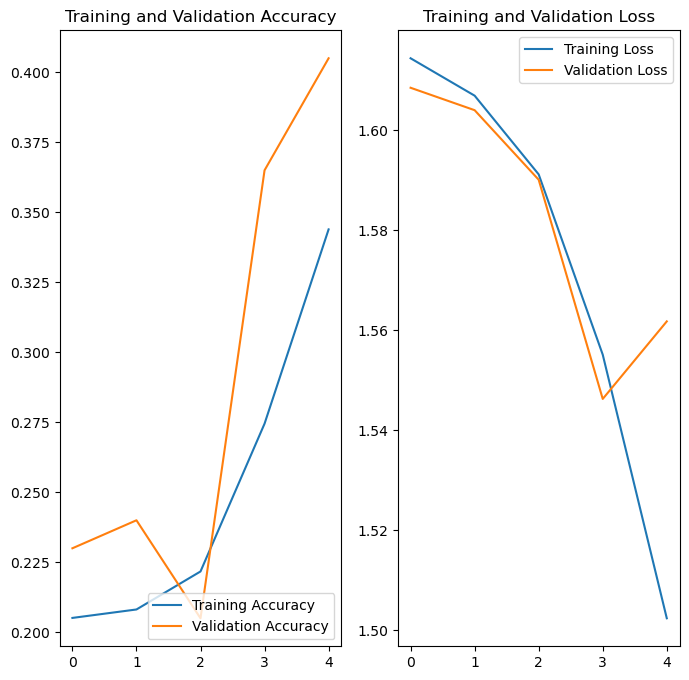

In [20]:
model3 = define_model3()
history3 = trigger_model(model3, train_path, train_doc, batch_size, augment=True, frames_to_sample=16, total_frames=30)
plot_graph(history3)

In [28]:
model3 = define_model3()
history3 = trigger_model(model3, train_path,train_doc, batch_size=20,augment=True,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=5)
plot_graph(history3 ,epochs=5)

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 1.6151 - categorical_accuracy: 0.2014 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2712_14_21.775741\model-00001-1.61512-0.20136-1.60559-0.18500.h5
34/34 [==============================] - 539s 16s/step - loss: 1.6151 - categorical_accuracy: 0.2014 - val_loss: 1.6056 - val_categorical_accuracy: 0.1850 - lr: 2.0000e-04
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 1.6027 - categorical_accuracy: 0.2262 
Epoch 2: saving model to model_init_2024-02-2712_14_21.775741\model-00002-1.60266-0.22624-1.60416-0.32500.h5
34/34 [==============================] - 587s 17s/step - loss: 1.6027 - categorical_accuracy: 0.2262 - val_loss: 1.6042 - val_categorical_accuracy: 0.3250 - lr: 2.0000e-04
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 1.5643 - categorical_accuracy: 0.2745 
Epoch 3: savin

TypeError: plot_graph() missing 1 required positional argument: 'epochs'

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.1825 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2619_55_42.136406\model-00001-1.60945-0.18250-1.60933-0.22000.h5
34/34 [==============================] - 416s 12s/step - loss: 1.6095 - categorical_accuracy: 0.1825 - val_loss: 1.6093 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.1840 
Epoch 2: saving model to model_init_2024-02-2619_55_42.136406\model-00002-1.60940-0.18401-1.60949-0.15000.h5
34/34 [==============================] - 472s 14s/step - loss: 1.6094 - categorical_accuracy: 0.1840 - val_loss: 1.6095 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.1780 
Epoch 3: savin

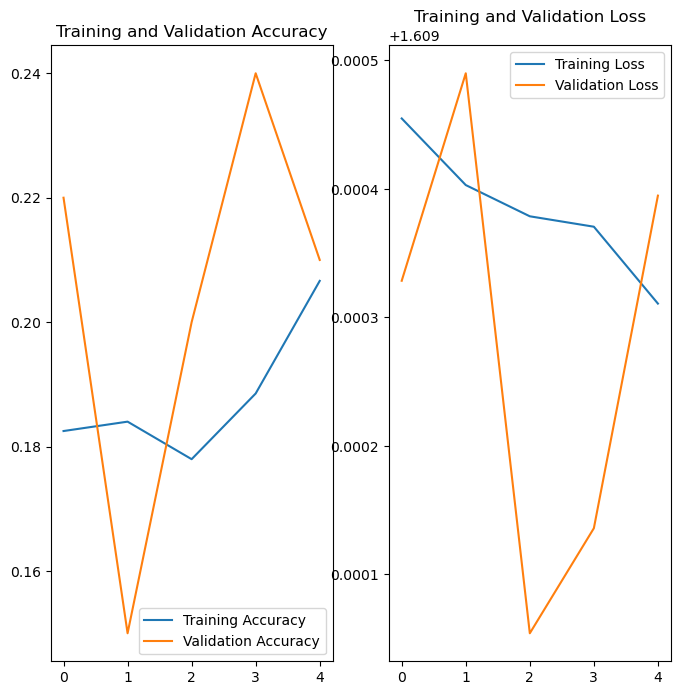

In [22]:
model4 = define_model4()
history4 = trigger_model(model4, train_path, train_doc, batch_size, augment=False, frames_to_sample=16, total_frames=30)
plot_graph(history4)

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 1.7548 - categorical_accuracy: 0.1855 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2619_55_42.136406\model-00001-1.75481-0.18552-1.60760-0.22000.h5
34/34 [==============================] - 454s 13s/step - loss: 1.7548 - categorical_accuracy: 0.1855 - val_loss: 1.6076 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 1.6523 - categorical_accuracy: 0.1976 
Epoch 2: saving model to model_init_2024-02-2619_55_42.136406\model-00002-1.65234-0.19759-1.60920-0.18000.h5
34/34 [==============================] - 471s 14s/step - loss: 1.6523 - categorical_accuracy: 0.1976 - val_loss: 1.6092 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 1.6428 - categorical_accuracy: 0.1893 
Epoch 3: savin

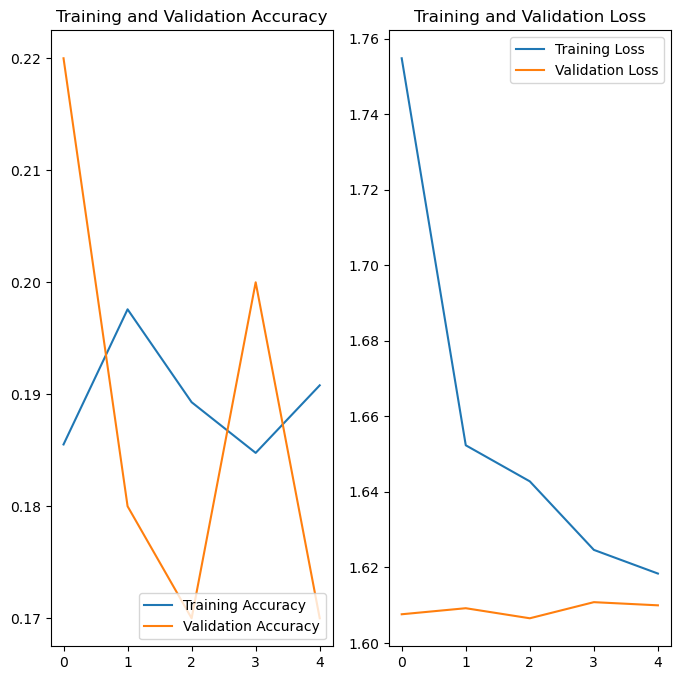

In [23]:
model4 = define_model4()
history4 = trigger_model(model4, train_path, train_doc, batch_size, augment=True, frames_to_sample=16, total_frames=30)
plot_graph(history4)

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 1.7430 - categorical_accuracy: 0.2104 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2712_14_21.775741\model-00001-1.74299-0.21041-1.60881-0.23000.h5
34/34 [==============================] - 841s 24s/step - loss: 1.7430 - categorical_accuracy: 0.2104 - val_loss: 1.6088 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 1.6498 - categorical_accuracy: 0.1923 
Epoch 2: saving model to model_init_2024-02-2712_14_21.775741\model-00002-1.64985-0.19231-1.60823-0.21000.h5
34/34 [==============================] - 946s 28s/step - loss: 1.6498 - categorical_accuracy: 0.1923 - val_loss: 1.6082 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 1.6402 - categorical_accuracy: 0.1908 
Epoch 3: savin

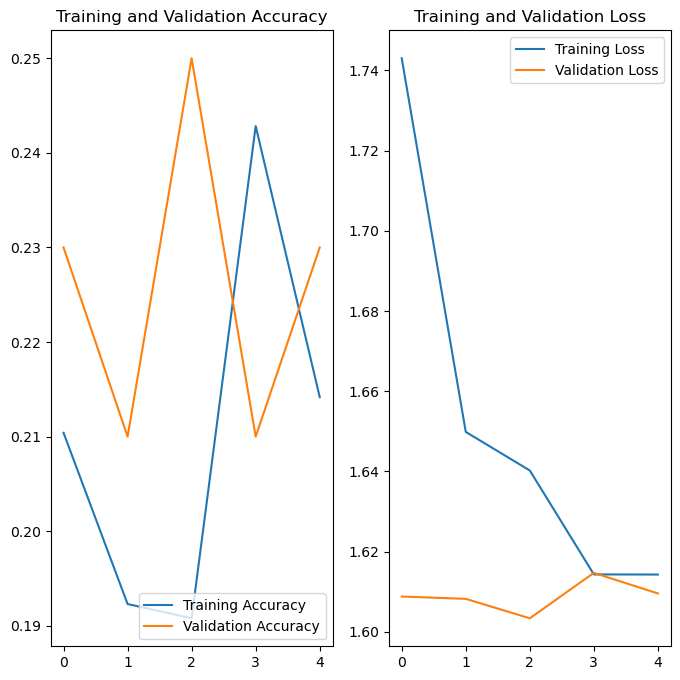

In [30]:
model4 = define_model4()
history4 = trigger_model(model4, train_path,train_doc, batch_size=20,augment=True,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=5)
plot_graph(history4,epochs=5)

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 1.8550 - categorical_accuracy: 0.1916 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2712_14_21.775741\model-00001-1.85503-0.19155-1.61526-0.23000.h5
34/34 [==============================] - 828s 24s/step - loss: 1.8550 - categorical_accuracy: 0.1916 - val_loss: 1.6153 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 1.7567 - categorical_accuracy: 0.1795 
Epoch 2: saving model to model_init_2024-02-2712_14_21.775741\model-00002-1.75673-0.17949-1.63340-0.25000.h5
34/34 [==============================] - 844s 24s/step - loss: 1.7567 - categorical_accuracy: 0.1795 - val_loss: 1.6334 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 1.7171 - categorical_accuracy: 0.1825 
Epoch 3: savin

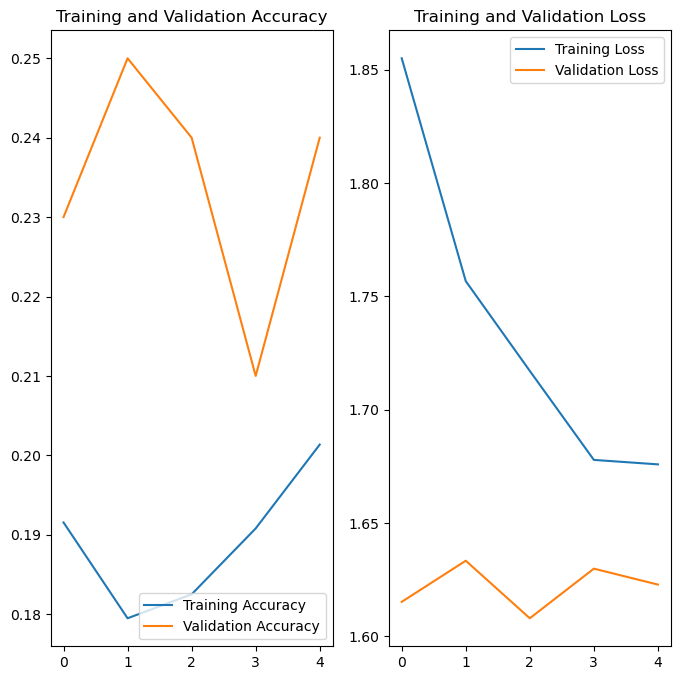

In [31]:
model5 = define_model5()
history5 = trigger_model(model5, train_path,train_doc, batch_size=20,augment=True,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=5)
plot_graph(history5,epochs=5)

In [ ]:
model6 = define_model6()
history5 = trigger_model(model6, train_path,train_doc, batch_size=20,augment=True,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=5)
plot_graph(history6,epochs=5)

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 1.6101 - categorical_accuracy: 0.1961 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2712_14_21.775741\model-00001-1.61011-0.19608-1.60925-0.23000.h5
34/34 [==============================] - 751s 22s/step - loss: 1.6101 - categorical_accuracy: 0.1961 - val_loss: 1.6093 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.2157 
Epoch 2: saving model to model_init_2024-02-2712_14_21.775741\model-00002-1.60953-0.21569-1.60872-0.16000.h5
34/34 [==============================] - 747s 22s/step - loss: 1.6095 - categorical_accuracy: 0.2157 - val_loss: 1.6087 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 1.6101 - categorical_accuracy: 0.1968 
Epoch 3: savin